In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn

In [5]:
df = pd.read_csv("netflix.csv")

In [6]:
print(df.head())

         Date      High       Low      Open     Close     Volume  Adj Close
0  23-05-2002  1.242857  1.145714  1.156429  1.196429  104790000   1.196429
1  24-05-2002  1.225000  1.197143  1.214286  1.210000   11104800   1.210000
2  28-05-2002  1.232143  1.157143  1.213571  1.157143    6609400   1.157143
3  29-05-2002  1.164286  1.085714  1.164286  1.103571    6757800   1.103571
4  30-05-2002  1.107857  1.071429  1.107857  1.071429   10154200   1.071429


In [7]:
closed_prices = df["Close"]

In [32]:
seq_len = 15

In [33]:
print(closed_prices)

0         1.196429
1         1.210000
2         1.157143
3         1.103571
4         1.071429
           ...    
4876    634.809998
4877    639.099976
4878    631.849976
4879    632.659973
4880    627.039978
Name: Close, Length: 4881, dtype: float64


In [9]:
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [10]:
X = []
y = []

In [11]:
for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [12]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

# Train and test

In [13]:
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

# LSTM

In [26]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 96)

In [27]:
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [28]:
num_epochs = 100

In [29]:
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.0073453174
20 epoch loss 0.005185687
30 epoch loss 0.004540631
40 epoch loss 0.0042023105
50 epoch loss 0.0036945608
60 epoch loss 0.002933821
70 epoch loss 0.0013689045
80 epoch loss 0.0005561548
90 epoch loss 0.0001911552


In [30]:
model.eval()
with torch.no_grad():
    output = model(test_x)

In [31]:
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

# Plotting

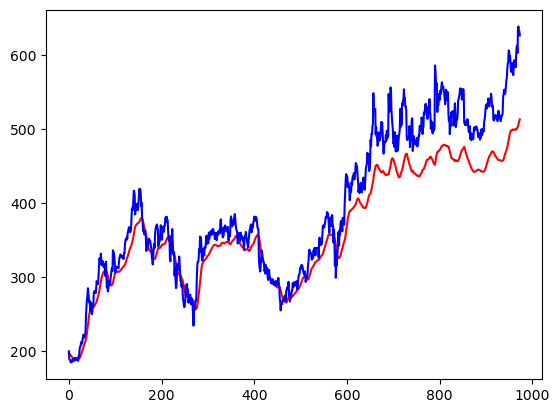

In [25]:
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "blue" , label = "real")
plt.show()
